In [60]:
import os
from dotenv import load_dotenv
from pathlib import Path

NOTEBOOK_PATH = Path().resolve()
dotenv_path = NOTEBOOK_PATH / "postgres.env"
load_dotenv(dotenv_path)

DBHOST = os.environ.get("DBHOST")
DBPORT = os.environ.get("DBPORT")
DBUSER = os.environ.get("DBUSER")
DBNAME = os.environ.get("DBNAME")
DBPASS = os.environ.get("DBPASS")

In [61]:
from sqlalchemy import create_engine, URL

engine_url = URL.create(
    drivername="postgresql+psycopg2",
    username=DBUSER,
    password=DBPASS,
    host=DBHOST,
    port=DBPORT,
    database=DBNAME,
)

engine = create_engine(url=engine_url)

In [257]:
import pandas as pd

query = """
            SELECT 
                p.name,
                p.latitude,
                p.longitude,
                d.year, 
                d.month, 
                d.day, 
                r.amount
            FROM rainfall r
            JOIN places p
            ON p.place_id = r.place_id
            JOIN dates d
            on r.date_id = d.date_id
            ;
        """

df = pd.read_sql(query, engine)

# geo_df = geopandas.GeoDataFrame(
#     df,
#     geometry=geopandas.points_from_xy(df.longitude, df.latitude),
#     crs="EPSG:4326"
# )

grouped_df = df.groupby(by=["year", "month", "name", "day"]).first()
idx = pd.IndexSlice

to_drop = grouped_df[grouped_df.isna().any(axis=1)].index.get_level_values(2).unique()

for name in to_drop:
    grouped_df.drop(name, level='name', inplace=True)


test_df = grouped_df.loc[idx[2019, 8],].groupby(by=["name"]).agg({"latitude": "first", "longitude": "first", "amount":"sum" })


test_df.index

Index(['ALABAT, QUEZON', 'AMBULONG, BATANGAS', 'APARRI, CAGAYAN',
       'BAGUIO CITY, BENGUET', 'BALER, AURORA (RADAR)', 'BASCO, BATANES',
       'BORONGAN, EASTERN SAMAR', 'BUTUAN CITY, AGUSAN DEL NORTE',
       'CABANATUAN, NUEVA ECIJA', 'CALAPAN, ORIENTAL MINDORO',
       'CALAYAN, CAGAYAN', 'CASIGURAN, AURORA', 'CATARMAN, NORTHERN SAMAR',
       'CATBALOGAN, WESTERN SAMAR', 'CLARK INTERNATIONAL AIRPORT, PAMPANGA',
       'CORON, PALAWAN', 'COTABATO CITY, MAGUINDANAO',
       'CUBI PT., SUBIC BAY OLONGAPO CITY, ZAMBALES', 'CUYO, PALAWAN',
       'DAET, CAMARINES NORTE', 'DAGUPAN CITY, PANGASINAN',
       'DAVAO CITY, DAVAO DEL SUR', 'DIPOLOG, ZAMBOANGA DEL NORTE',
       'DUMAGUETE CITY, NEGROS ORIENTAL', 'GENERAL SANTOS, SOUTH COTABATO',
       'GUIUAN, EASTERN SAMAR', 'HINATUAN, SURIGAO DEL SUR', 'IBA, ZAMBALES',
       'INFANTA, QUEZON', 'ITBAYAT, BATANES', 'LAOAG CITY, ILOCOS NORTE',
       'LEGASPI CITY, ALBAY', 'LUMBIA AIRPORT, MISAMIS ORIENTAL',
       'MAASIN, SOUTHERN LEYT

In [63]:
import geopandas

# ph_shp = geopandas.read_file(
#     NOTEBOOK_PATH / 
#     "raw_files" / 
#     "Shapefile" / 
#     "PH_Adm0_Country.shp.zip",
#     crs="EPSG:32651"
# )

ph_shp = geopandas.read_file(
    NOTEBOOK_PATH / 
    "raw_files" / 
    "Shapefile" / 
    "PH_Adm2_ProvDists.shp.zip",
    crs="EPSG:4326"
)

In [64]:
ph_shp = ph_shp.to_crs("EPSG:4326")

<Axes: >

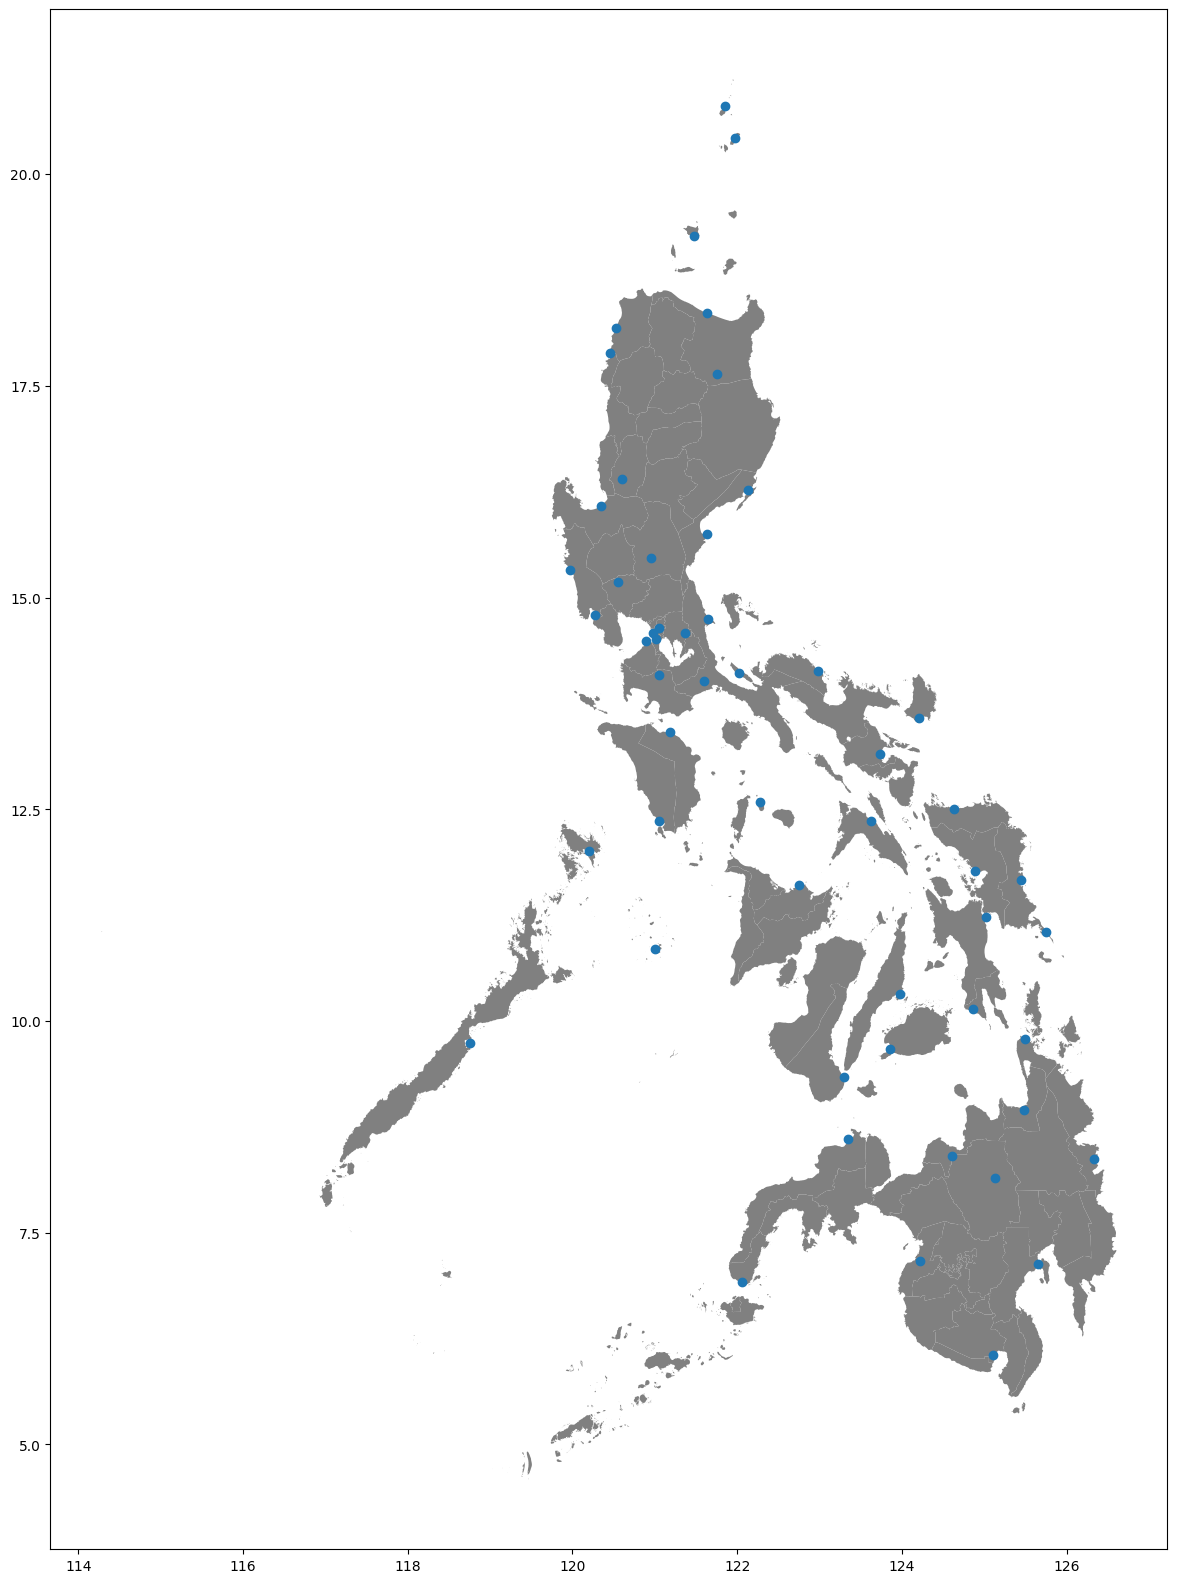

In [260]:

geo_df = geopandas.GeoDataFrame(
    test_df,
    geometry=geopandas.points_from_xy(test_df.longitude, test_df.latitude),
    crs="EPSG:4326"
)


ax = ph_shp.plot(figsize=(20,20), color="gray")
geo_df.plot(ax=ax)


In [102]:
import numpy as np
from shapely.geometry import Polygon

minx, miny, maxx, maxy = ph_shp.total_bounds

grid_space = 0.1

grid_lon = list(np.arange(minx, maxx+grid_space, grid_space))
grid_lat = list(np.arange(miny, maxy+grid_space, grid_space))

polygons = []
for lon in grid_lon[:-1]:
    for lat in grid_lat[:-1]:
        polygons.append(Polygon([(lon, lat), 
                                 (lon+grid_space, lat),
                                 (lon+grid_space, lat+grid_space),
                                 (lon, lat+grid_space),
                                 ]
                                )
                        )

square_grid = geopandas.GeoDataFrame(
        geometry=polygons,
        crs="EPSG:4326"
    )


<Axes: >

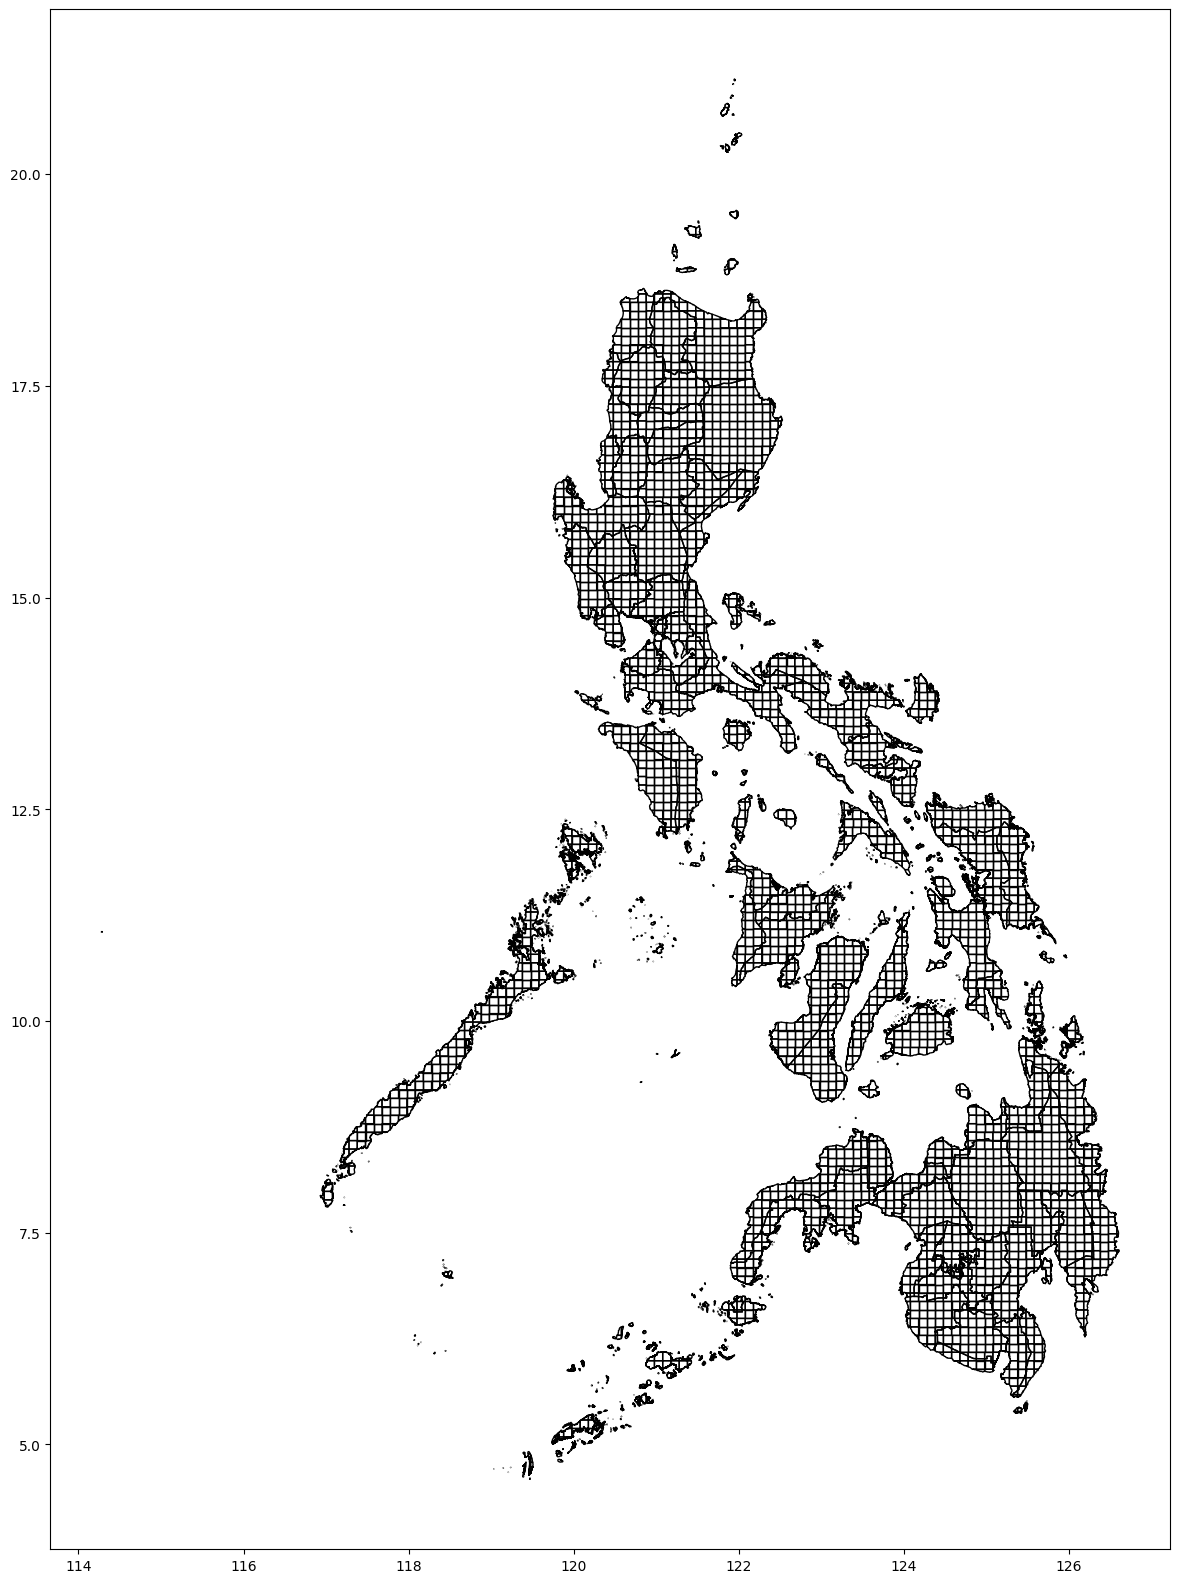

In [103]:
intersection2 = square_grid.overlay(ph_shp, how="intersection")

intersection2.plot(figsize=(20,20), facecolor="None", edgecolor="black")

In [261]:
from sklearn.neighbors import KNeighborsRegressor

x = test_df[["longitude", "latitude"]]
y = test_df[["amount"]]

model = KNeighborsRegressor(algorithm="kd_tree", n_neighbors=8, weights="distance").fit(x,y)

d:\Philippines-Rainfall-Data\.venv\Lib\site-packages\geopandas\geodataframe.py:1528: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
d:\Philippines-Rainfall-Data\.venv\Lib\site-packages\geopandas\geodataframe.py:1528: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


<Axes: >

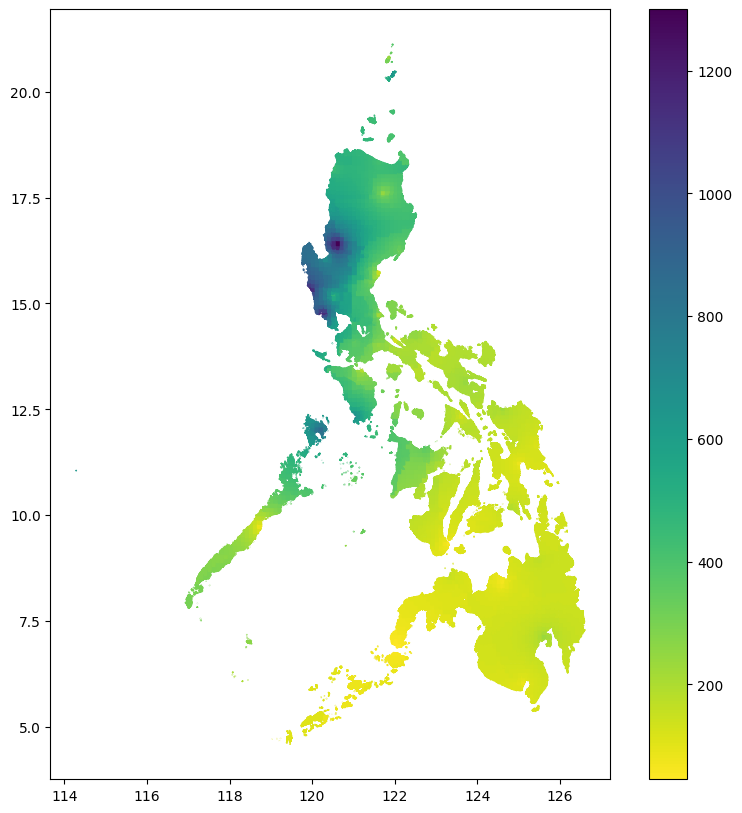

In [262]:
intersection2 = intersection2[["geometry"]]
intersection2["longitude"] = intersection2.apply(lambda row: row["geometry"].centroid.x, axis=1)

intersection2["latitude"] = intersection2.apply(lambda row: row["geometry"].centroid.y, axis=1)
prediction2 = model.predict(intersection2[["longitude", "latitude"]])

intersection2["amount"] = pd.Series(prediction2[:, 0])

intersection2.plot(
    column="amount", 
    figsize=(10,10), 
    legend=True, 
    edgecolor="face", 
    linewidth=1,
    cmap="viridis_r")